# Exercise: Fine-tune BERT with Keras NLP, using Yelp reviews

In this exercise we will see how the Keras NLP package works.  
We will load a pre-trained BERT and fine-tune it to classify Yelp reviews as good=1 or bad=0

Keras NLP is an extension, not part of Keras/Tensorflow base

Keras NLP has several versions of BERT available (as mention in slides) so we will also see how differently they run for performance and time - look for the  "<<<<-----" markers to see what to change

This tutorial is based on: https://keras.io/guides/keras_nlp/getting_started/

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' #suppress warnings
import tensorflow as tf
tf.__version__

'2.12.0'

In [2]:
#Run this first to see if keras-nlp installed
!pip show keras_nlp


Name: keras-nlp
Version: 0.5.1
Summary: Industry-strength Natural Language Processing extensions for Keras.
Home-page: https://github.com/keras-team/keras-nlp
Author: Keras team
Author-email: keras-nlp@google.com
License: Apache License 2.0
Location: /scratch/train138/job_23650733/miniconda3/envs/keras-nlp/lib/python3.11/site-packages
Requires: absl-py, numpy, packaging, tensorflow-text
Required-by: 


In [3]:
import keras_nlp
import tensorflow_text

In [5]:
#----------------------data prep -------------------------------
#from sklearn.preprocessing import scale
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd  


In [6]:
#Read in review texts and ratings for the hard cases, and easy cases
textin=[] 
ic=0;

# <<-- optionally, there is a _500_ sample text file
#First read in hard to classificy text strings with their ratings
with open(r'./yelprev_100_text.txt','r',encoding='UTF-8') as f:
    for line in f: 
        textin.append(line.rstrip())

ratesin=[];ic=0;
with open(r'./yelprev_100_rating.txt','r',encoding='UTF-8') as f:
    for line in f: 
        rateval = int(line.rstrip())
        rateval = np.round(0.05+ (rateval-1)/4)  #for numbers 1,2,3,4,5 make 1,2=class 0;make 3,4,5=class 1
        ratesin.append(rateval)

print(len(textin))  

100


In [9]:
#Prepare Data
#Split data into train and validation  
num4train = int(0.8*len(textin) )

X_trn     = textin[0:num4train]
X_val     = textin[num4train:]
Y_trn     = ratesin[0:num4train]
Y_val     = ratesin[num4train:]

#Now combine data into 1 tensforflow dataset (which will help the fit function get batches for training)
batch_size=16

#For TRAINING DATA, it has both X,Y data, so it's ready for the 'fit' function
textin_trn_ds   = tf.data.Dataset.from_tensor_slices((X_trn,Y_trn)) 
textin_trn_ds   = textin_trn_ds.batch(batch_size) #give batches of 10 to train 

#For VALID DATA
textin_val_ds   = tf.data.Dataset.from_tensor_slices((X_val,Y_val))
textin_val_ds = textin_val_ds.batch(batch_size) #give batches of 10 to train 



In [10]:
#Here's a few reviews from the dataset iterator
for elem in textin_trn_ds.take(1):  #each element has batchsize number of reviews
  batchstrings=elem[0].numpy()
  print(batchstrings[0:1])
  break

[b"Sometimes, you go to their main office thinking you would get things done faster. I came to get my electric transferred to a new location and they want more identifications. It's crazy but they want you to sign you life away. All this information is already in the system and they want more. Not only did I waste my time but got sent home to get more id's. It's ridiculous how redounded they are. Driver's license check, social security ??? who carries their social security cards with them anymore. All this information, already in the system but they still need it. Worst policies and procedures."]


In [11]:
#set up the name to use below for getting the model, and processors

# <<<<<<<<<------------ try different sizes 
model_string_name="bert_small_en_uncased"      #28M parameters
#model_string_name="bert_medium_en_uncased"      #41M parameters
#model_string_name="bert_base_en"               #108M parameters

mymodel = keras_nlp.models.BertClassifier.from_preset(model_string_name,num_classes=2)
mymodel.summary()


Preprocessor: "bert_preprocessor"
__________________________________________________________________________________________________
 Tokenizer (type)                                    Vocab #     
 bert_tokenizer (BertTokenizer)                      30522       
__________________________________________________________________________________________________
                                                                                                  
Model: "bert_classifier"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 padding_mask (InputLayer)      [(None, None)]       0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, None)]       0           []                               
                 

In [12]:
#You might use these in other situations
#tokenizer2use    = keras_nlp.models.BertTokenizer.from_preset(model_string_name)
#preprocessor2use = keras_nlp.models.BertPreprocessor.from_preset( model_string_name, sequence_length=512)



In [13]:
#You do not need to run compile, unless you want to change the pretrained defaults 
if 0:
    mymodel.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.experimental.AdamW(0.0001),  #5e-5),  
    metrics=tf.keras.metrics.SparseCategoricalAccuracy(),
    jit_compile=True )


In [14]:
#We can also get the loss scores before any fine tuning
mymodel.evaluate(textin_val_ds)


2/2 [==============================] - 5s 1s/step - loss: 0.6807 - sparse_categorical_accuracy: 0.6000


[0.680748462677002, 0.6000000238418579]

In [15]:
myES = tf.keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', mode='max', patience=5,  restore_best_weights=True) 

fit_history=mymodel.fit(textin_trn_ds,
    validation_data=textin_val_ds,
    epochs=10,shuffle=True,   #just run a few epochs
    callbacks=[myES])

print('done training')

Epoch 1/10
5/5 [==============================] - 37s 5s/step - loss: 0.5728 - sparse_categorical_accuracy: 0.7250 - val_loss: 0.7899 - val_sparse_categorical_accuracy: 0.6500
Epoch 2/10
5/5 [==============================] - 22s 4s/step - loss: 0.5428 - sparse_categorical_accuracy: 0.7500 - val_loss: 0.6300 - val_sparse_categorical_accuracy: 0.6500
Epoch 3/10
5/5 [==============================] - 22s 5s/step - loss: 0.4724 - sparse_categorical_accuracy: 0.7500 - val_loss: 0.6409 - val_sparse_categorical_accuracy: 0.6500
Epoch 4/10
5/5 [==============================] - 22s 5s/step - loss: 0.3787 - sparse_categorical_accuracy: 0.7875 - val_loss: 0.6207 - val_sparse_categorical_accuracy: 0.6500
done training


dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


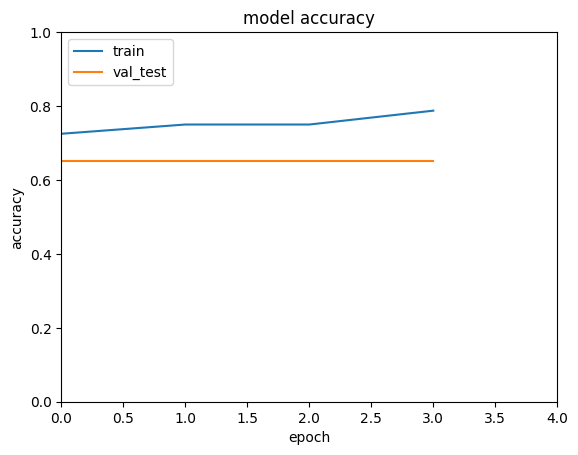

In [16]:
import matplotlib.pyplot as plt      #These provide matlab type of plotting functions
import matplotlib.image as mpimg
%matplotlib inline                   

# list all data in history and print out performance
print(fit_history.history.keys())
numtraining_epochs=len(fit_history.history['sparse_categorical_accuracy'])
# summarize history for accuracy
plt.figure()
plt.axis([0 ,numtraining_epochs, 0, 1])
plt.plot(fit_history.history['sparse_categorical_accuracy'])
plt.plot(fit_history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val_test'], loc='upper left')
plt.show()

In [17]:
#Now, let's get the validation predictions after fine tuning
# and then look at some predictions and the text
aftfinetune_predictions=mymodel.predict(textin_val_ds)  #the dataset will just pass in list of strings


2/2 [==============================] - 4s 1s/step


In [18]:
#each element is a batch-size set of reviews and a batch-szie set of targets 
#each review is a tensor, each target is a tensor
incnt=0
for elem in textin_val_ds:  
  for i in range(batch_size):
    print('----------------------------------------------------------------------')
    print('item number: ',incnt)
    print(tf.get_static_value(elem[0][i]))  #each item is a tensor
    maxposition=np.argmax(aftfinetune_predictions[incnt,])  #should be -1 or 1
    print('prediction values: ',aftfinetune_predictions[incnt,])
    print( ' and class predictn:',maxposition, ' true:',tf.get_static_value(elem[1][i]))
    print('------------------------------------------------------------------------')
    incnt+=1
    if incnt>5:
        break


----------------------------------------------------------------------
item number:  0
b'Very good place.  Casual, comfortable.  Slightly hip in a nice, effortless way.  Pleasant outdoor seating.  The dining room is also cool -- small, intimate and relaxed.  Three Flags is a great oasis in its neighborhood.  The brisket burger and fries were very good and I would enjoy one again.  It is not over-the-top great as some reviews suggest, so temper your expectations.  The cauliflower gratin (with some broccoli) was superb, though.  It is not my impression of gratin.  The cauliflower is served roasted or grilled with cheese sprinkled on and a bit of oil and seasoning.  Might not sound like much, but if you have any interest in cauliflower, have it.  It is that good.'
prediction values:  [-0.91660154  0.9028212 ]
 and class predictn: 1  true: 1.0
------------------------------------------------------------------------
----------------------------------------------------------------------
item